In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
from gym_stock_trading_env import StockTradingEnv
from functions.strategy import PercentChangeStrategy, ExtremaStrategy
from functions.strategy import PercentChangeStrategy, ExtremaStrategy
from functions.position_size import all_in_position_sizing
from functions.risk_management import risk_management
from functions.reward_functions import reward_function
from functions.transaction_cost import transaction_cost_function
from functions.other_utils import state_transformation, logging_callback

In [2]:
def custom_render(env):
    clear_output(wait=True)
    plt.figure(figsize=(12, 6))
    plt.plot(env.df['Close'][:env.current_step+1], label='Close Price')
    
    current_price = env.df['Close'].iloc[env.current_step]
    plt.scatter(env.current_step, current_price, color='red', marker='o', s=100, label='Current Price')
    
    # Plot trade markers.
    buys = [t for t in env.trade_history if t['action'] == 'buy']
    sells = [t for t in env.trade_history if t['action'] == 'sell']
    if buys:
        plt.scatter([t['step'] for t in buys], [t['price'] for t in buys],
                    color='green', marker='^', s=100, label='Buy')
    if sells:
        plt.scatter([t['step'] for t in sells], [t['price'] for t in sells],
                    color='black', marker='v', s=100, label='Sell')
    
    plt.title(f"Step: {env.current_step} | Total Asset: {env.total_asset_value:.2f}")
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.legend()
    plt.show()
    # Pause briefly to ensure the plot updates.
    time.sleep(0.5)

In [3]:

df = yf.download("AAPL", start="2022-01-01", end="2023-01-01")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2022-01-03,178.879883,179.734931,174.653844,174.771775,104487900
2022-01-04,176.609650,179.793936,176.039622,179.489269,99310400
2022-01-05,171.911865,177.071580,171.636682,176.521213,94537600
2022-01-06,169.042053,172.285305,168.688244,169.730012,96904000
2022-01-07,169.209152,171.145275,168.088758,169.916771,86709100
...,...,...,...,...,...
2022-12-23,130.344513,130.898074,128.150027,129.415314,63814900
2022-12-27,128.535522,129.899667,127.240581,129.870013,69007800


In [5]:

env = StockTradingEnv(df, initial_balance=10000, transaction_cost_pct=0.001, custom_render=custom_render)

c:\Users\mikol\OneDrive\Pulpit\Projekty_prywatne\Stock-trading-Reinforcement-Learning\gym_stock_trading_env.py:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(self.df.loc[self.current_step, 'Close'])


In [6]:
# Choose a strategy.
strategy = ExtremaStrategy(window=3)

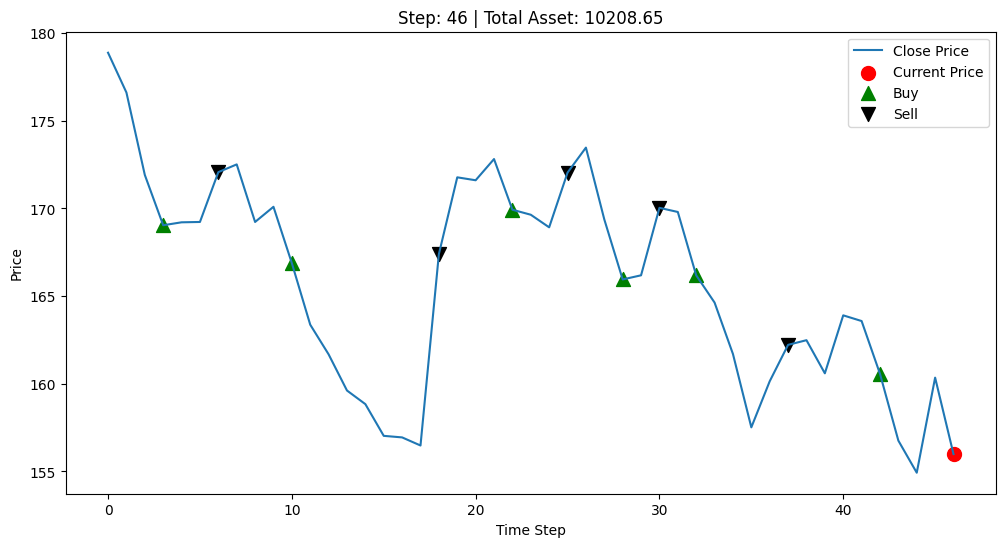

KeyboardInterrupt: 

In [8]:
# Reset the environment.
obs = env.reset()
done = False
step = 0

while not done:
    # Transform the state.
    state = state_transformation(obs)
    
    # Get the action from the chosen strategy.
    action = strategy.get_action(env)
    
    # Determine position sizing (all in).
    quantity = all_in_position_sizing(state, env, action)
    
    # Risk management.
    action, quantity = risk_management(state, env, action, quantity)
    
    # Transaction cost adjustments.
    quantity = transaction_cost_function(state, env, action, quantity)
    
    # Execute the step.
    obs, raw_reward, done, info = env.step((action, quantity))
    
    # Compute final reward.
    final_reward = reward_function(state, env, raw_reward, info)
    
    # Logging.
    logging_callback(step, state, action, quantity, final_reward, info)
    
    # Render the updated plot.
    env.render()
    
    step += 1